<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 758, done.
remote: Total 758 (delta 0), reused 0 (delta 0), pack-reused 758
Receiving objects: 100% (758/758), 118.40 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Updating files: 100% (129/129), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16619 sha256=403ebd9032f3dac677995206937f7d83218f13899a6e9c08d24d6622d9a4ab5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-uwc705v8/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [ ]:
# %tensorflow_version 1.x
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import csv

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset.

Execute the cell below to visualize our datasets.

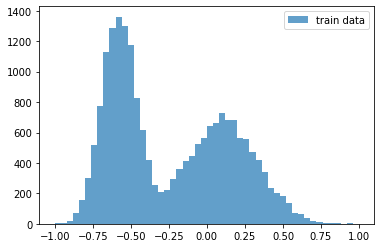

In [ ]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution.



### Solution

In [ ]:
# training pineline
def train(train_loader, generator, discriminator, g_optimizer, d_optimizer, n_critic=1, device='cuda', non_saturating=False):
  d_losses, g_losses = [], []
  generator.train()
  discriminator.train()
  # for i, x in enumerate(tqdm_notebook(train_loader, desc='Batch', leave=False)):
  for i, x in enumerate(train_loader):
    x = x.to(device).float()
    d_loss = -( discriminator(x).log() + (1- discriminator(generator.sample(x.shape[0]))).log() ).mean()
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    d_losses.append(d_loss.item())

    if i% n_critic ==0 :
      if non_saturating:
        g_loss = - discriminator(generator.sample(x.shape[0])).log().mean()
      else:
        g_loss = (1- discriminator(generator.sample(x.shape[0]))).log().mean()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()
      g_losses.append(g_loss.item())
  return g_losses, d_losses

def train_epoch(train_loader, discriminator, generator, epochs, non_saturating=False):
  train_loss = {'g':[], 'd':[]}
  g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.9))
  d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0, 0.9))
  for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
    if epoch == 0:
      snap_epoch1 = get_snapshot(generator, discriminator, n_samples=5000)

    g_losses, d_losses = train(train_loader, generator, discriminator, g_optimizer, d_optimizer, n_critic=2, non_saturating=non_saturating)
    train_loss['g'].extend(g_losses)
    train_loss['d'].extend(d_losses)

  snap_final = get_snapshot(generator, discriminator, n_samples=5000)

  return train_loss, *snap_epoch1, *snap_final

def get_snapshot(generator, discriminator, n_samples=5000, device='cuda'):
  generator.eval()
  discriminator.eval()
  xs = np.linspace(-1, 1, 1000)
  discriminator_output = discriminator(torch.Tensor(xs).to(device).float().unsqueeze(1)).detach().cpu().numpy()
  samples = generator.sample(n_samples).detach().cpu().numpy()
  return samples, xs, discriminator_output

In [ ]:
# model
class SimpleGenerator(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, device='cuda'):
    super().__init__()
    self.latent_dim = input_size
    self.device = device
    net = []
    for i in range(len(hidden_size)):
      net.extend([nn.Linear(input_size, hidden_size[i]), nn.LeakyReLU(0.2)])
      input_size = hidden_size[i]
    net.append(nn.Linear(hidden_size[-1], output_size))
    self.mlp = nn.Sequential(*net)

  def forward(self, z):
    return torch.tanh(self.mlp(z))

  def sample(self, n):
    """
      n = batch_size
    """
    z = torch.distributions.Normal(torch.zeros(self.latent_dim), torch.ones(self.latent_dim)).sample((n, )).to(self.device) # [n, latent_dim]
    return self.forward(z) # [n, output_size]

class SimpleDiscriminator(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    net = []
    for i in range(len(hidden_size)):
      net.extend([nn.Linear(input_size, hidden_size[i]), nn.LeakyReLU(0.2)])
      input_size = hidden_size[i]
    net.append(nn.Linear(hidden_size[-1], output_size))
    self.mlp = nn.Sequential(*net)

  def forward(self, x):
    return torch.sigmoid(self.mlp(x))

In [ ]:
def q1_a(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at the end of training
  """

  """ YOUR CODE HERE """
  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  generator = SimpleGenerator(1, [128, 128, 128], 1).to(device)
  # print(generator)
  discriminator = SimpleDiscriminator(1, [128, 128, 128], 1).to(device)
  # print(discriminator)

  train_losses, samples_1, xs_1, d_output_1, samples_final, xs_final, d_output_final =  train_epoch(train_loader, discriminator, generator, epochs=25)
  return train_losses['d'], samples_1, xs_1, d_output_1, samples_final, xs_final, d_output_final

### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

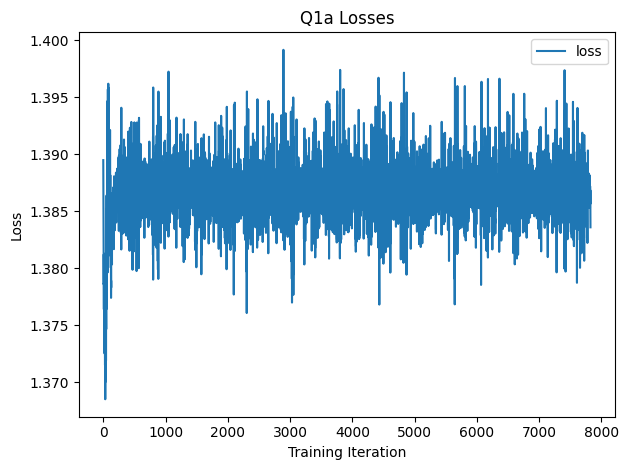

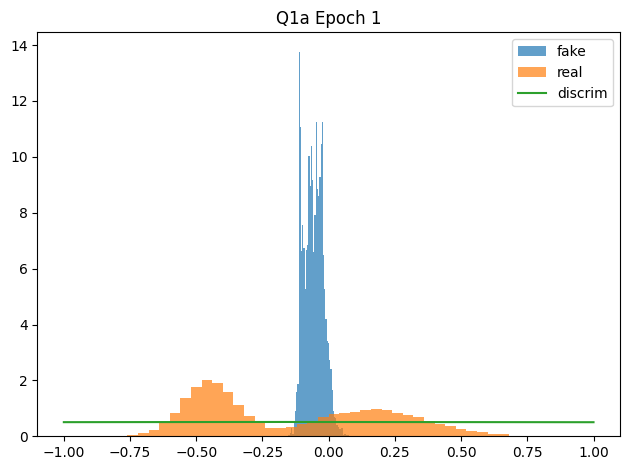

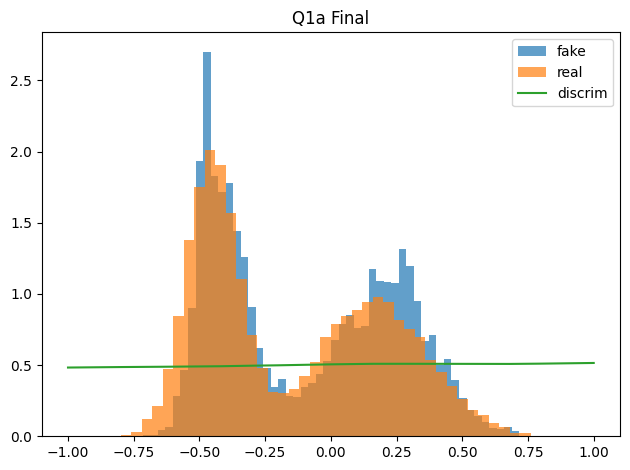

In [ ]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [ ]:
def q1_b(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at the end of training
  """

  """ YOUR CODE HERE """
  train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  generator = SimpleGenerator(1, [128, 128, 128], 1).to(device)
  discriminator = SimpleDiscriminator(1, [128, 128, 128], 1).to(device)

  train_losses, samples_1, xs_1, d_output_1, samples_final, xs_final, d_output_final =  train_epoch(train_loader, discriminator, generator, epochs=25, non_saturating=True)
  return train_losses['d'], samples_1, xs_1, d_output_1, samples_final, xs_final, d_output_final

 ### Results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

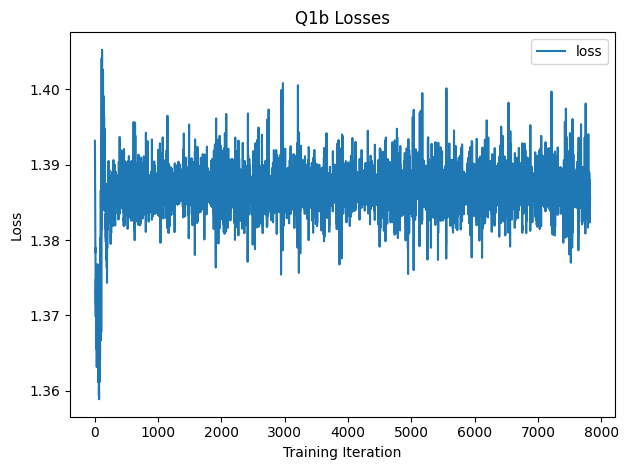

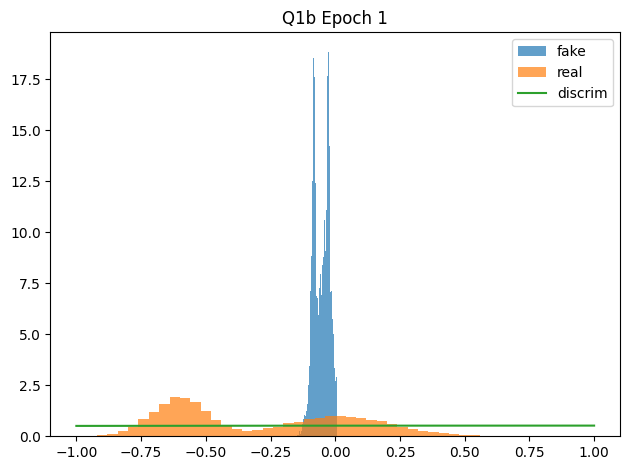

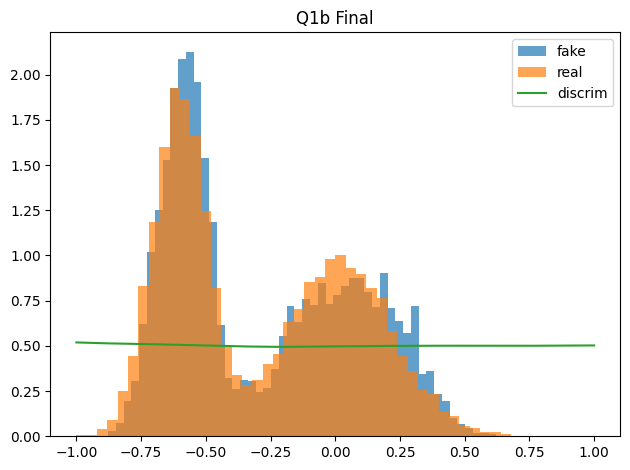

In [ ]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset.

Files already downloaded and verified


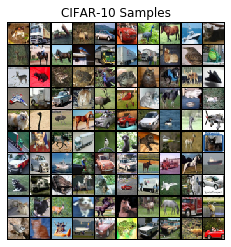

In [ ]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states.

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training.

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples.

## Solution

In [ ]:
# model
class DepthToSpace(nn.Module):
  """
    For up-sampling
  """
  def __init__(self, block_size):
    super().__init__()
    self.block_size = block_size
    self.block_size_sq = block_size * block_size

  def forward(self, x):
    # print('dts ', x.shape)
    output = x.permute(0, 2, 3, 1)  # [b, h, w, d]
    b, d_height, d_width, d_depth = output.shape
    # print('d_height ', d_height)
    # print('d_width ', d_width)
    # print('d_depth', d_depth)
    # new shape
    s_depth = d_depth // self.block_size_sq
    s_height = d_height * self.block_size
    s_width = d_width * self.block_size
    # print('s_depth ', s_depth)
    # print('s_height ', s_height)
    # print('s_width ', s_width)
    t_1 = output.reshape(b, d_height, d_width, self.block_size_sq, s_depth)
    spl = t_1.split(self.block_size, 3)  # block_size x [b, d_height, d_width, block_size, s_depth]
    stack = [t_t.reshape(b, d_height, s_width, s_depth) for t_t in spl]
    output = torch.stack(stack, dim=0).transpose(0, 1)  # [b, block_size, d_height, s_width, s_depth]
    output = output.permute(0, 2, 1, 3, 4).reshape(b, s_height, s_width, s_depth)
    # print('dts ', output.shape)
    output = output.permute(0, 3, 1, 2)
    # print('dts ', output.shape)
    return output


class Upsample_Conv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    super().__init__()
    self.conv2d = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
    self.dts = DepthToSpace(block_size=2)

  def forward(self, x):
    x = torch.cat([x, x, x, x], dim=1)  # [b, 4*in_dim, h, w]
    x = self.dts(x)                     # [b, in_dim, 2*h, 2*w]
    x = self.conv2d(x)                  # [b, out_dim, 2*h, 2*w]
    return x

class SpaceToDepth(nn.Module):
  """
    For down-sampling
  """
  def __init__(self, block_size):
    super().__init__()
    self.block_size = block_size
    self.block_size_sq = block_size**2

  def forward(self, x):
    output = x.permute(0, 2, 3, 1)   # [b, s_height, s_width, s_depth]
    b, s_height, s_width, s_depth = output.shape
    # new shape
    d_depth = s_depth*self.block_size_sq
    d_height = s_height//self.block_size
    d_width = s_width//self.block_size
    t_1 = output.split(self.block_size, dim=2)   # d_width x [b, s_height, block_size, s_depth]
    stack = [t_t.reshape(b, d_height, d_depth) for t_t in t_1]
    output = torch.stack(stack, dim=1)          # [b, d_width, d_height, d_depth]
    output = output.permute(0, 3, 2, 1)         # [b, d_depth, d_height, d_width]
    return output


class Downsample_Conv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    super().__init__()
    self.conv2d = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
    self.std = SpaceToDepth(2)

  def forward(self, x):
    x = self.std(x)                       # [b, 4*in_dim, h/2, w/2]
    x = sum(x.chunk(4, dim=1))/4.0        # [b, in_dim, h/2, w/2]
    x = self.conv2d(x)                    # [b, out_dim, h/2, w/2]
    return x


class ResnetBlockUp(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
    super().__init__()
    self.net1 = nn.Sequential(nn.BatchNorm2d(in_dim),
                              nn.ReLU(),
                              nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                              nn.BatchNorm2d(n_filters),
                              nn.ReLU(),
                              Upsample_Conv2d(n_filters, n_filters, kernel_size))
    self.net2 = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

  def forward(self, x):
    # print('up ', x.shape)
    # print('up2 ', self.net2(x).shape)
    # print('up1 ', self.net1(x).shape)
    return self.net1(x) + self.net2(x)  # [b, n_filters, 2*h, 2*w]


class ResnetBlockDown(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
    super().__init__()
    self.net1 = nn.Sequential(nn.ReLU(),
                              nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                              nn.ReLU(),
                              Downsample_Conv2d(n_filters, n_filters, kernel_size))
    self.net2 = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

  def forward(self, x):
    return self.net1(x) + self.net2(x)  # [b, n_filters, h/2, w/2]


class ResnetBlock(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3)):
    super().__init__()
    self.net = nn.Sequential(nn.ReLU(),
                             nn.Conv2d(in_dim, in_dim, kernel_size, padding=1),
                             nn.ReLU(),
                             nn.Conv2d(in_dim, in_dim, kernel_size, padding=1))

  def forward(self, x):
    return x + self.net(x)    # [b, in_dim, h, w]


class Generator(nn.Module):
  def __init__(self, n_filters=128, device='cuda'):
    super().__init__()
    self.device = device
    self.linear = nn.Linear(128, 4*4*256)
    self.block = nn.Sequential(ResnetBlockUp(in_dim=256, n_filters=n_filters),
                               ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                               ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                               nn.BatchNorm2d(n_filters),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, 3, (3, 3), padding=1),
                               nn.Tanh())

  def forward(self, z):
    """
      Input: z [b, 128]
    """
    # print('gen ', z.shape)
    z = self.linear(z)      # [b, 4*4*256]
    # print('gen ', z.shape)
    z = z.reshape(z.shape[0], 256, 4, 4)
    # print('gen ', z.shape)
    # for i in self.block:
    #   print(i)
    #   z = i(z)
    #   print('block gen ', z.shape)
    z = self.block(z)       # [b, 3, 32, 32]
    # print('gen ', z.shape)
    return z

  def sample(self, n_samples):
    z = torch.distributions.Normal(torch.zeros(128), torch.ones(128)).sample((n_samples,)).to(self.device)
    return self.forward(z)  # [n_samples, 3, 32, 32]


class Discriminator(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.block = nn.Sequential(ResnetBlockDown(in_dim=3, n_filters=n_filters),
                               ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                               ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                              #  ResnetBlock(in_dim=n_filters),
                              #  ResnetBlock(in_dim=n_filters),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, 256, kernel_size=(3, 3), padding=1))
    self.linear = nn.Sequential(nn.Linear(4*4*256 , 128),
                                nn.ReLU(),
                                nn.Linear(128, 1))

  def forward(self, x):
    """
      Input: x [b, 3, 32, 32]
    """
    # print('dis ', x.shape)
    x = self.block(x)   # [b, 256, 4, 4]
    x = x.reshape(x.shape[0], 256*4*4)
    x = self.linear(x)  # [b, 1]
    return x


# class Discriminator(nn.Module):
#   def __init__(self, n_filters=128):
#     super().__init__()
#     self.block = nn.Sequential(ResnetBlockDown(in_dim=3, n_filters=n_filters),
#                                ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
#                                ResnetBlock(in_dim=n_filters),
#                                ResnetBlock(in_dim=n_filters),
#                                nn.ReLU())
#     self.linear = nn.Sequential(nn.Linear(128, 1))

#   def forward(self, x):
#     """
#       Input: x [b, 3, 32, 32]
#     """
#     # print('dis ', x.shape)
#     x = self.block(x)   # [b, 128, 4, 4]
#     x = torch.sum(x, dim=(2, 3))
#     x = self.linear(x)  # [b, 1]
#     return x

In [ ]:
import csv
def gradient_penalty(real_data, fake_data, d, device='cuda'):
  b = real_data.shape[0]

  eps = torch.rand(b, 1, 1, 1).to(device)
  interpolations = torch.tensor(eps*real_data + (1-eps)*fake_data, requires_grad=True)
  d_output = d(interpolations)

  gradients = torch.autograd.grad(outputs=d_output, inputs= interpolations, grad_outputs=torch.ones(d_output.size()).to(device),
                                  create_graph=True, retain_graph=True)[0]
  gradients = gradients.reshape(b, -1)
  gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=-1) + 1e-12)
  return ((gradients_norm-1)**2).mean()

def train(train_loader, g, d, n_iterations=50000, n_critic=5, device='cuda'):
  current_itr = 0

  # n_epochs = n_critic * n_iterations // len(train_loader)
  n_epochs = 100
  lr_lambda = lambda epoch: (n_epochs - epoch) / n_epochs
  # optimizer with lr scheduler
  g_optimizer = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0, 0.9))
  g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lr_lambda)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0, 0.9))
  d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)

  # tranining loop
  train_losses = []
  for epoch in tqdm_notebook(range(1, n_epochs+1), desc='Epoch', leave=False):
    g.train()
    d.train()
    batch_losses = []
    for i, x in enumerate(tqdm_notebook(train_loader, desc='Batch', leave=False)):
      current_itr +=1
      x = x.to(device).float()*2-1 # rescale image [-1, 1]
      # print('data ', x.shape)
      d_optimizer.zero_grad()
      fake_data = g.sample(x.shape[0])
      gp = gradient_penalty(x, fake_data, d)
      d_loss = -(d(x) - d(fake_data)).mean() + 10*gp
      d_loss.backward()
      d_optimizer.step()

      if current_itr%n_critic==0:
        g_optimizer.zero_grad()
        fake_data = g.sample(x.shape[0])
        g_loss = - d(fake_data).mean()
        g_loss.backward()
        g_optimizer.step()

        batch_losses.append(g_loss.item())
        # print(f'Epoch {epoch}: d_loss: {d_loss.item()}, gp: {gp}, g_loss: {g_loss}, lr: {g_optimizer.param_groups[0]["lr"]}')

    if epoch % 5== 0 or epoch==1:
        # sample imgs
        sampled_imgs = g.sample(100).permute(0, 2, 3, 1).detach().cpu()
        imgs = np.zeros((320, 320, 3))
        for i in range(10):
          for j in range(10):
            idx = i*10 +j
            imgs[i*32:(i+1)*32, j*32:(j+1)*32, :] = sampled_imgs[idx, :, :, :]
        imgs = imgs*0.5 + 0.5
        plt.imshow(imgs)
        plt.savefig(f'sampled_imgs_epoch{epoch}.png')

    # update lr
    g_scheduler.step()
    d_scheduler.step()
    # save d_loss
    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    with open('d_train_loss.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      for i in train_losses:
        writer.writerow([i])
  return train_losses

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1].
        The first 100 will be displayed, and the rest will be used to calculate the Inception score.
    """

    """ YOUR CODE HERE """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    g = Generator(n_filters=128).to(device)
    d = Discriminator(n_filters=128).to(device)
    # print(g)
    # print(d)
    # return

    train_losses = train(train_loader, g, d, n_iterations=25000, n_critic=5, device=device)

    g.eval()
    with torch.no_grad():
      samples = g.sample(1000).permute(0, 2, 3, 1).cpu().numpy()*0.5 + 0.5

    return train_losses, samples

## Results

Files already downloaded and verified


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

..........Inception score: 6.062441


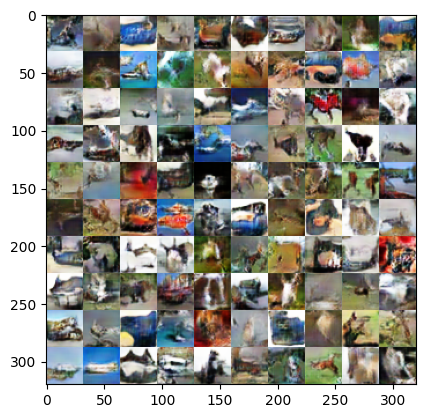

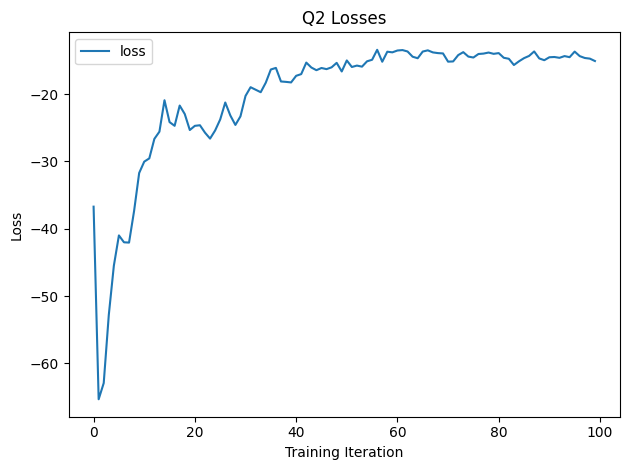

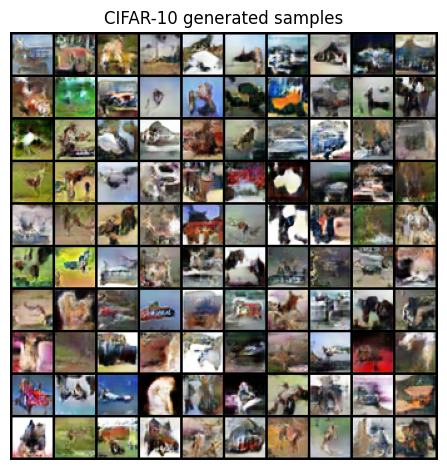

In [ ]:
q2_save_results(q2)

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done!


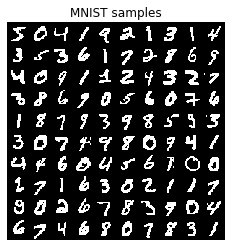

In [ ]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$.

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks.

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these.

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss.

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term.
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder.
5. Final test losses for the two linear classifiers.

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
# # model
class Generator(nn.Module):
  def __init__(self, latent_dim, image_dim=28*28):
    super().__init__()
    self.net = nn.ModuleList([nn.Linear(latent_dim, 1024),
                              nn.ReLU(),
                              nn.Linear(1024, 1024),
                              nn.BatchNorm1d(1024, affine=False),
                              nn.ReLU(),
                              nn.Linear(1024, image_dim),
                              nn.Tanh()])

  def forward(self, x):
    for f in self.net:
      x = f(x)
    return x.view(x.shape[0], 1, 28, 28) # [b, 1, 28, 28]

class Discriminator(nn.Module):
  def __init__(self, latent_dim, image_dim=28*28):
    super().__init__()
    self.net = nn.ModuleList([nn.Linear(latent_dim+image_dim, 1024),
                              nn.LeakyReLU(0.2),
                              nn.Linear(1024, 1024),
                              nn.BatchNorm1d(1024, affine=False),
                              nn.LeakyReLU(0.2),
                              nn.Linear(1024, 1),
                              nn.Sigmoid()])

  def forward(self, x, z):
    '''
      x: [batch, 1, 28, 28]
      z: [batch, latent_dim]
    '''
    x = x.view(x.shape[0], -1) # flatten
    x = torch.cat([x, z], dim=1)
    for f in self.net:
      x = f(x)
    return x  # [b, 1]

class Encoder(nn.Module):
  def __init__(self, latent_dim, image_dim=28*28):
    super().__init__()
    self.net = nn.ModuleList([nn.Linear(image_dim, 1024),
                              nn.LeakyReLU(0.2),
                              nn.Linear(1024, 1024),
                              nn.BatchNorm1d(1024, affine=False),
                              nn.LeakyReLU(0.2),
                              nn.Linear(1024, latent_dim)])

  def forward(self, x):
    '''
      x: [batch, 1, 28, 28]
    '''
    x = x.view(x.shape[0], -1)  # flatten
    for f in self.net:
      x = f(x)
    return x # [b, latent_dim]


class Classifier(nn.Module):
  def __init__(self, latent_dim=50):
    super().__init__()
    self.net = nn.Linear(latent_dim, 10)

  def forward(self, x):
    return self.net(x)

In [ ]:
def train_bigan(train_loader, g, e, d, n_epochs=100, device='cuda'):
  # optimizer with lr scheduler
  lr_lambda = lambda epoch: (n_epochs - epoch) / n_epochs
  g_e_optimizer = torch.optim.Adam(list(g.parameters())+list(e.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
  g_e_scheduler = torch.optim.lr_scheduler.LambdaLR(g_e_optimizer, lr_lambda)
  # d_optimizer = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0, 0.9), weight_decay=2.5e-5)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0, 0.9))
  d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)

  # tranining loop
  train_losses = []
  for epoch in tqdm_notebook(range(1, n_epochs+1), desc='Epoch', leave=False):
    g.train()
    d.train()
    e.train()
    batch_losses = []
    for i, (x, _) in enumerate(tqdm_notebook(train_loader, desc='Batch', leave=False)):
      x = x.to(device).float().view(x.shape[0], 1, 28, 28) # [b, 1, 28, 28]
      # update discriminator
      d_optimizer.zero_grad()
      z = torch.distributions.Normal(0.0, 1.0).sample((x.shape[0], 50)).to(device)
      d_loss = -0.5*torch.log(d(x, e(x))).mean() - 0.5*torch.log(1-d(g(z), z)).mean()
      d_loss.backward()
      d_optimizer.step()
      batch_losses.append(d_loss.item())

      # update generator and encoder
      g_e_optimizer.zero_grad()
      z = torch.distributions.Normal(0.0, 1.0).sample((x.shape[0], 50)).to(device)
      g_e_loss = 0.5*torch.log(d(x, e(x))).mean() + 0.5*torch.log(1-d(g(z), z)).mean()
      g_e_loss.backward()
      g_e_optimizer.step()

    # update lr
    g_e_scheduler.step()
    d_scheduler.step()

    # generate img each a number of epochs
    if epoch % 5== 0 or epoch==1:
        # sample imgs
        z = torch.distributions.Normal(0.0, 1.0).sample((100, 50)).to(device)
        sampled_imgs = g(z).permute(0, 2, 3, 1).detach().cpu()
        imgs = np.zeros((280, 280, 3))
        for i in range(10):
          for j in range(10):
            idx = i*10 +j
            imgs[i*28:(i+1)*28, j*28:(j+1)*28, :] = sampled_imgs[idx, :, :, :]
        plt.imshow(imgs)
        plt.savefig(f'sampled_imgs_epoch{epoch}.png')

    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
  return train_losses


def train_classifier(train_loader, test_loader, e, classifier, n_epochs=100, device='cuda'):
  optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

  train_losses = []
  val_losses = []
  for epoch in tqdm_notebook(range(1, n_epochs+1), desc='Epoch', leave=False):
    e.eval()
    classifier.train()
    batch_losses = []

    for batch_i, (x, y) in enumerate(tqdm_notebook(train_loader, desc='Batch', leave=False)):
      x = x.to(device).float().view(x.shape[0], 1, 28, 28)
      y = y.to(device)

      optimizer.zero_grad()
      y_pred = classifier(e(x).detach())
      loss = F.cross_entropy(y_pred, y)
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())

    # save training losses
    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    # evaluate the classifier
    val_losses.append(get_val_clsf_loss(test_loader, e, classifier, device))

  return train_losses, val_losses

def get_val_clsf_loss(test_loader, e, classifier, device='cuda'):
  e.eval()
  classifier.eval()
  val_acc_total = 0
  val_items = 0

  with torch.no_grad():
    for (x, y) in test_loader:
      x = x.to(device).float()
      y = y.to(device)

      logits = classifier(e(x))
      y_pred = torch.argmax(logits, dim=1)
      num_correct = torch.sum(y_pred == y).float().item()
      val_acc_total += num_correct
      val_items += x.shape[0]

  return val_acc_total/val_items

In [ ]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch
    """

    """ YOUR CODE HERE """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128, shuffle=True)
    g = Generator(latent_dim=50).to(device)
    d = Discriminator(latent_dim=50).to(device)
    e = Encoder(latent_dim=50).to(device)
    c = Classifier(latent_dim=50).to(device)

    # train classifier
    print('Training classifier with random encoder')
    c_train_loss, val_acc = train_classifier(train_loader, test_loader, e, c, n_epochs=50, device=device)
    print("Classifier accuracy: ", val_acc[-1])

    # train bigan
    print("Training Bigan")
    bigan_train_losses = train_bigan(train_loader, g, e, d, n_epochs=100, device=device)
    g.eval()
    e.eval()
    with torch.no_grad():
      # sample image
      z = torch.distributions.Normal(0.0, 1.0).sample((100, 50)).to(device)
      samples = g(z).permute(0, 2, 3, 1).cpu().numpy()
      # reconstruction
      x = (torch.Tensor(train_data.data[:20]).to(device).float().view(20, 1, 28, 28)/255.0)*2-1
      x_recon = g(e(x))  # [b, 1, 28, 28]
      recons = torch.cat([x, x_recon], dim=0).permute(0, 2, 3, 1).detach().cpu().numpy()

    # reset and retrain the classifier
    print('Training classifier with trained encoder')
    c = Classifier(latent_dim=50).to(device)
    c_train_loss_bigan, val_acc_bigan = train_classifier(train_loader, test_loader, e, c, n_epochs=50, device=device)
    print("FClassifier accuracy: ", val_acc_bigan[-1])

    return bigan_train_losses, samples, recons, c_train_loss_bigan, c_train_loss

## Results

100%|██████████| 9912422/9912422 [00:00<00:00, 94964210.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37878578.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27832900.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6082544.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training classifier with random encoder


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Classifier accuracy:  0.8232
Training Bigan


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Training classifier with trained encoder


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

FClassifier accuracy:  0.8636


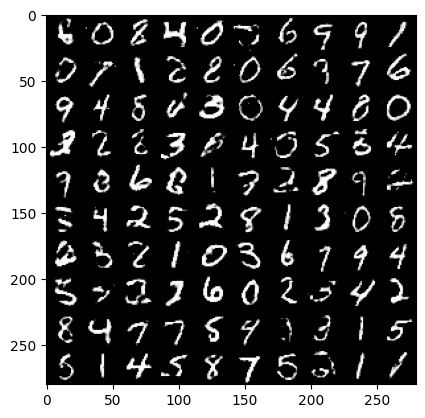

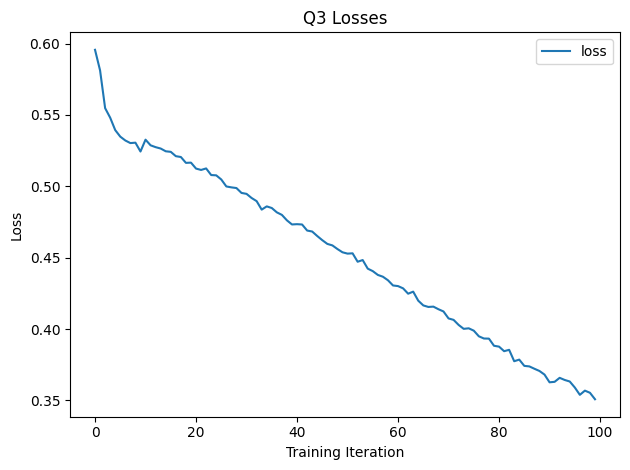

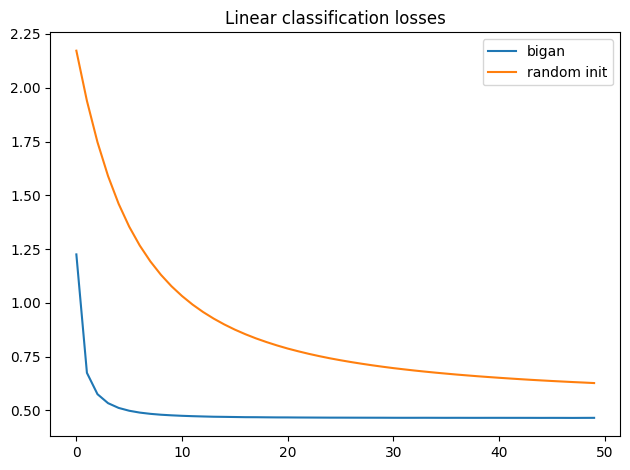

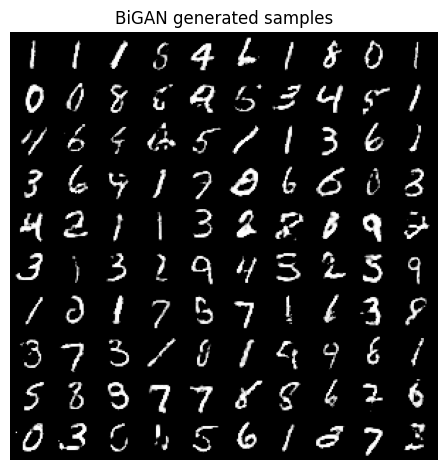

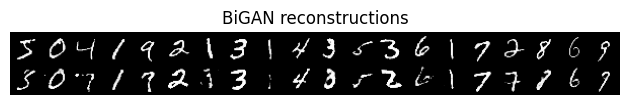

BiGAN final linear classification loss: 0.4655695568396847
Random encoder linear classification loss: 0.6272308886178267


In [ ]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST.

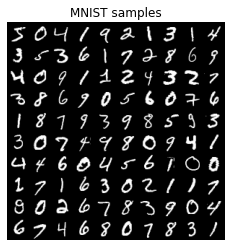

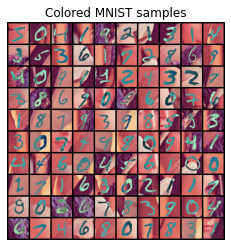

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain.

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models.

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain.
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions.

## Solution

In [ ]:
# class G_Generator(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.Encoder = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(7, 7), stride=1, padding=3),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(9, 18, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(9, affine=False),
#                                  nn.ReLU())
#     self.ResBlock = nn.Sequential(nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU(),
#                                   nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU(),
#                                   nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU())
#     self.Decoder = nn.Sequential(nn.ConvTranspose2d(18, 9, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.ConvTranspose2d(9, 3, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(3, 3, kernel_size=(7, 7), stride=1, padding=3),
#                                  nn.Tanh())

#   def forward(self, x):
#     x = self.Encoder(x)
#     x = self.ResBlock(x) + x
#     x = self.Decoder(x)*0.5 + 0.5
#     return x # [b, 3, 28, 28]

# class F_Generator(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.Encoder = nn.Sequential(nn.Conv2d(3, 3, kernel_size=(7, 7), stride=1, padding=3),
#                                  nn.InstanceNorm2d(9, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(9, 18, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(9, affine=False),
#                                  nn.ReLU())
#     self.ResBlock = nn.Sequential(nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU(),
#                                   nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU(),
#                                   nn.Conv2d(18, 18, kernel_size=(3, 3), stride=1, padding=1),
#                                   nn.InstanceNorm2d(9, affine=False),
#                                   nn.ReLU())
#     self.Decoder = nn.Sequential(nn.ConvTranspose2d(18, 9, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.ConvTranspose2d(9, 3, kernel_size=(4, 4), stride=2, padding=1),
#                                  nn.InstanceNorm2d(3, affine=False),
#                                  nn.ReLU(),
#                                  nn.Conv2d(3, 1, kernel_size=(7, 7), stride=1, padding=3),
#                                  nn.Tanh())

#   def forward(self, x):
#     x = self.Encoder(x)
#     x = self.ResBlock(x) + x
#     x = self.Decoder(x)*0.5 + 0.5
#     return x   # [b, 1, 28, 28]


# model
class G_Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.Encoder = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(3, affine=False),
                                 nn.ReLU(),
                                 nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(9, affine=False),
                                 nn.ReLU())
    self.ResBlock = nn.Sequential(nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU())
    self.Decoder = nn.Sequential(nn.ConvTranspose2d(9, 3, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(3, affine=False),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.Sigmoid())

  def forward(self, x):
    x = self.Encoder(x)
    x = self.ResBlock(x) + x
    x = self.Decoder(x)
    return x # [b, 3, 28, 28]

class F_Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.Encoder = nn.Sequential(nn.Conv2d(3, 3, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(3, affine=False),
                                 nn.ReLU(),
                                 nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(9, affine=False),
                                 nn.ReLU())
    self.ResBlock = nn.Sequential(nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(9, 9, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.InstanceNorm2d(9, affine=False),
                                  nn.ReLU())
    self.Decoder = nn.Sequential(nn.ConvTranspose2d(9, 3, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.InstanceNorm2d(3, affine=False),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(3, 1, kernel_size=(4, 4), stride=2, padding=1),
                                 nn.Sigmoid())

  def forward(self, x):
    x = self.Encoder(x)
    x = self.ResBlock(x) + x
    x = self.Decoder(x)
    return x   # [b, 1, 28, 28]

class X_Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(4, 4), stride=2,padding=1),
                               nn.InstanceNorm2d(3, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
                               nn.InstanceNorm2d(9, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(9, 18, kernel_size=(4, 4), stride=2, padding=1),
                               nn.InstanceNorm2d(18, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(18, 9, kernel_size=(4, 4), stride=1, padding=1),
                               nn.InstanceNorm2d(9, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(9, 1, kernel_size=(3, 3), stride=1, padding=1),
                               nn.Sigmoid())

  def forward(self, x):
    x = self.net(x)   # [b, 1, 2, 2]
    return x.mean(dim=[-3, -2, -1])

class Y_Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Conv2d(3, 3, kernel_size=(4, 4), stride=2,padding=1),
                               nn.InstanceNorm2d(3, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(3, 9, kernel_size=(4, 4), stride=2, padding=1),
                               nn.InstanceNorm2d(9, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(9, 18, kernel_size=(4, 4), stride=2, padding=1),
                               nn.InstanceNorm2d(18, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(18, 9, kernel_size=(4, 4), stride=1, padding=1),
                               nn.InstanceNorm2d(9, affine=False),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(9, 1, kernel_size=(4, 4), stride=1, padding=1),
                               nn.Sigmoid())

  def forward(self, x):
    x = self.net(x)   # [b, 1, 2, 2]
    return x.mean(dim=[-3, -2, -1])

In [ ]:
def train_cyclegan(mnist_train_loader, cmnist_train_loader, g, f, d_x, d_y, n_epochs=100, device='cuda'):
  current_itr = 0
  n_critics = 5

  # optimizer with lr scheduler
  lr_lambda = lambda epoch: (n_epochs - epoch) / n_epochs
  g_f_optimizer = torch.optim.Adam(list(g.parameters())+list(f.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
  g_f_scheduler = torch.optim.lr_scheduler.LambdaLR(g_f_optimizer, lr_lambda)
  d_optimizer = torch.optim.Adam(list(d_x.parameters())+list(d_y.parameters()), lr=2e-4, betas=(0, 0.9))
  d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)

  # tranining loop
  train_losses = []
  for epoch in tqdm_notebook(range(1, n_epochs+1), desc='Epoch', leave=False):
    data_iter_mnist = iter(mnist_train_loader)
    data_iter_cmnist = iter(cmnist_train_loader)
    g.train()
    f.train()
    d_x.train()
    d_y.train()
    batch_losses = []
    for i in tqdm_notebook(range(len(mnist_train_loader)), desc='Batch', leave=False):
      current_itr += 1
      x= next(data_iter_mnist)
      x = x.to(device).float().view(x.shape[0], 1, 28, 28)
      y = next(data_iter_cmnist)
      y = y.to(device).float().view(x.shape[0], 3, 28, 28)
      # update discriminator
      d_optimizer.zero_grad()
      d_loss = -torch.log(d_y(y)).mean() - torch.log(1-d_y(g(x))).mean() - torch.log(d_x(x)).mean() - torch.log(1-d_x(f(y))).mean() - 10*torch.sum((x-f(g(x)))**2, dim=[1, 2, 3]).mean() - 10*torch.sum((y-g(f(y)))**2, dim=[1, 2, 3]).mean()
      # alternative formulation of loss function
      # d_loss = 0.5*torch.mean((d_y(y)-1)**2) + 0.5*torch.mean(d_y(g(x))**2) + 0.5*torch.mean((d_x(x)-1)**2) + 0.5*torch.mean(d_x(f(y))**2) - 10*torch.sum((x-f(g(x)))**2, dim=[1, 2, 3]).mean() - 10*torch.sum((y-g(f(y)))**2, dim=[1, 2, 3]).mean()
      d_loss.backward()
      d_optimizer.step()
      batch_losses.append(d_loss.item())

      # update generator and encoder
      if current_itr%n_critics==0:
        g_f_optimizer.zero_grad()
        g_f_loss = +torch.log(d_y(y)).mean() + torch.log(1-d_y(g(x))).mean() + torch.log(d_x(x)).mean() + torch.log(1-d_x(f(y))).mean() + 10*torch.mean((x-f(g(x)))**2) + 10*torch.mean((y-g(f(y)))**2)
        g_gan_loss = torch.log(1-d_y(g(x))).mean() +  torch.log(1-d_x(f(y))).mean()
        cycle_loss = torch.log(1-d_x(f(y))).mean() + 10*torch.mean((x-f(g(x)))**2) + 10*torch.mean((y-g(f(y)))**2)

        # alternative formulation of loss function
        # g_f_loss = -0.5*torch.mean((d_y(y)-1)**2) - 0.5*torch.mean(d_y(g(x))**2) - 0.5*torch.mean((d_x(x)-1)**2) - 0.5*torch.mean(d_x(f(y))**2) + 10*torch.sum((x-f(g(x)))**2, dim=[1, 2, 3]).mean() + 10*torch.sum((y-g(f(y)))**2, dim=[1, 2, 3]).mean()
        # g_gan_loss = - 0.5*torch.mean(d_y(g(x))**2) - 0.5*torch.mean(d_x(f(y))**2)
        # cycle_loss = 10*torch.sum((x-f(g(x)))**2, dim=[1, 2, 3]).mean() + 10*torch.sum((y-g(f(y)))**2, dim=[1, 2, 3]).mean()

        g_f_loss.backward()
        g_f_optimizer.step()
      if current_itr%5==0:
        print(f'Epoch {epoch}: g_gan_loss: {g_gan_loss.item()}, cycle_loss: {g_f_loss.item()}, d_lr: {d_optimizer.param_groups[0]["lr"]}, g_lr: {g_f_optimizer.param_groups[0]["lr"]}')

    # update lr
    g_f_scheduler.step()
    d_scheduler.step()
    # print(f'Epoch {epoch}: d_loss: {d_loss.item()}, g_loss: {g_f_loss.item()}, lr: {g_f_optimizer.param_groups[0]["lr"]}')

    # observe results after each 5 epochs
    if epoch % 5== 0 or epoch==1:
        # sample imgs
        for x in mnist_train_loader:
          x = x.to(device).float().view(x.shape[0], 1, 28, 28)
          break
        for y in cmnist_train_loader:
          y = y.to(device).float().view(x.shape[0], 3, 28, 28)
          break

        x, y = x[:6*12, :, :, :], y[:6*12, :, :, :]
        real_v_fake_mnist = torch.cat((x, f(y)), dim=0).permute(0, 2, 3, 1).detach().cpu()
        real_v_fake_cmnist = torch.cat((y,g(x)), dim=0).permute(0, 2, 3, 1).detach().cpu()
        real_v_fake_mnist_imgs = np.zeros((28*12, 28*12, 1))
        real_v_fake_cmnist_imgs = np.zeros((28*12, 28*12, 3))
        for i in range(12):
          for j in range(12):
            idx = i*12 +j
            real_v_fake_mnist_imgs[i*28:(i+1)*28, j*28:(j+1)*28, :] = real_v_fake_mnist[idx, :, :, :]
            real_v_fake_cmnist_imgs[i*28:(i+1)*28, j*28:(j+1)*28, :] = real_v_fake_cmnist[idx, :, :, :]
        # save imgs
        plt.imshow(real_v_fake_mnist_imgs)
        plt.savefig(f'real_v_fake_mnists_imgs_epoch{epoch}.png')
        plt.imshow(real_v_fake_cmnist_imgs)
        plt.savefig(f'real_v_fake_cmnist_imgs_epoch{epoch}.png')

    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    with open('cyclegan_d_train_loss.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      for i in train_losses:
        writer.writerow([i])
  return train_losses

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mnist_train_loader = data.DataLoader(mnist_data, batch_size=128, shuffle=True)
    cmnist_train_loader = data.DataLoader(cmnist_data, batch_size=128, shuffle=True)
    iter_mnist = iter(mnist_train_loader)
    iter_cmnist = iter(cmnist_train_loader)

    g = G_Generator().to(device)
    f =  F_Generator().to(device)
    d_x = X_Discriminator().to(device)
    d_y = Y_Discriminator().to(device)


    # train bigan
    print("Training CycleGAN")
    train_losses = train_cyclegan(mnist_train_loader, cmnist_train_loader, g, f, d_x, d_y, n_epochs=100, device='cuda')
    g.eval()
    f.eval()
    with torch.no_grad():
      x = next(iter_mnist)
      x = x.to(device).float().view(x.shape[0], 1, 28, 28)
      y = next(iter_cmnist)
      y = y.to(device).float().view(y.shape[0], 3, 28, 28)
      idx = torch.randint(0, 127, (20,))
      x, y = x[idx], y[idx]
      x1 = x.permute(0, 2, 3, 1).detach().cpu().numpy()
      x2 = g(x).permute(0, 2, 3, 1).detach().cpu().numpy()
      x3 = f(g(x)).permute(0, 2, 3, 1).detach().cpu().numpy()
      y1 = y.permute(0, 2, 3, 1).detach().cpu().numpy()
      y2 = f(y).permute(0, 2, 3, 1).detach().cpu().numpy()
      y3 = g(f(y)).permute(0, 2, 3, 1).detach().cpu().numpy()

    return x1, x2, x3, y1, y2, y3

## i encounter exploding vanishing gradient when training this model and something like model colapse

## Results

In [ ]:
q4_save_results(q4)